**Importing Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

**Train Data**

In [2]:
train= pd.read_csv('/content/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Visualizing Features VS Survival Rate**

In [3]:
test= pd.read_csv('/content/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


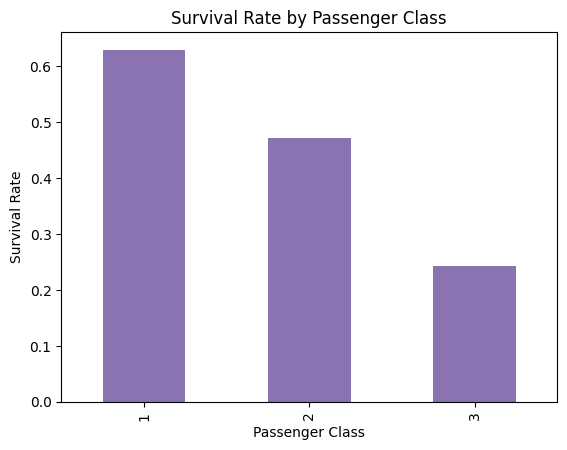

In [4]:
survival_rate = train.groupby('Pclass')['Survived'].mean()
survival_rate.plot(kind='bar', color='#8B72B1')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

In [5]:
women = train.loc[train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [6]:
men = train.loc[train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of mrn who survived:", rate_men)

% of mrn who survived: 0.18890814558058924


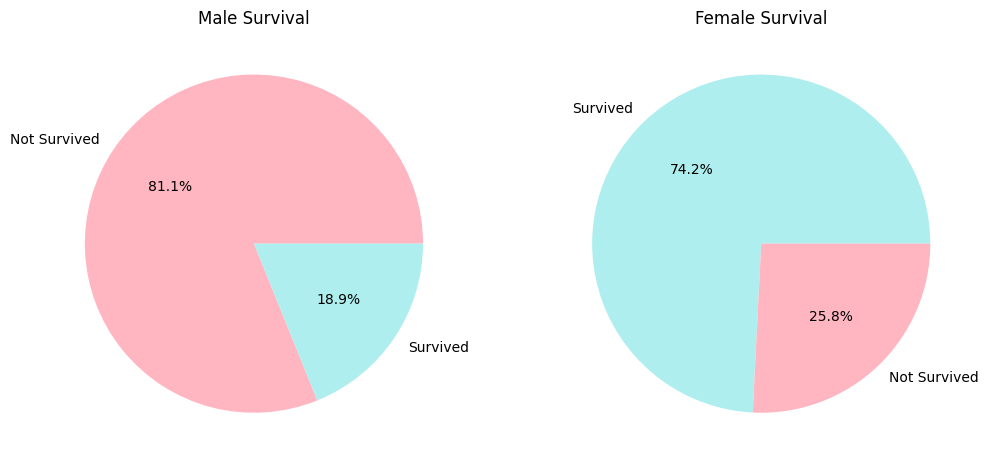

In [7]:
male_survival = train[train['Sex'] == 'male']['Survived'].value_counts()
female_survival = train[train['Sex'] == 'female']['Survived'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].pie(male_survival, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['#FFB6C1', '#AFEEEE'])
ax[0].set_title('Male Survival')
ax[1].pie(female_survival, labels=['Survived', 'Not Survived'], autopct='%1.1f%%', colors=['#AFEEEE', '#FFB6C1'])
ax[1].set_title('Female Survival')
plt.show()

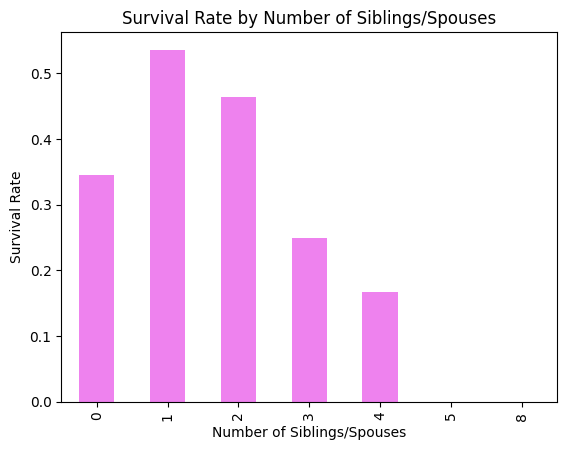

In [8]:
sibsp_survival = train.groupby('SibSp')['Survived'].mean()
sibsp_survival.plot(kind='bar', color='#EE82EE')
plt.title('Survival Rate by Number of Siblings/Spouses')
plt.xlabel('Number of Siblings/Spouses')
plt.ylabel('Survival Rate')
plt.show()

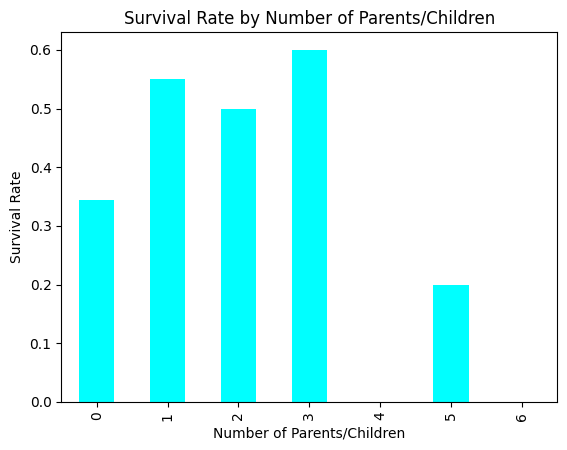

In [9]:
parch_survival = train.groupby('Parch')['Survived'].mean()
parch_survival.plot(kind='bar', color='#00FFFF')
plt.title('Survival Rate by Number of Parents/Children')
plt.xlabel('Number of Parents/Children')
plt.ylabel('Survival Rate')
plt.show()

**Preparing Data to Train and Validate**

In [10]:
def prepare_data(train, test, features):
    X = pd.get_dummies(train[features])
    X_test = pd.get_dummies(test[features])
    y = train["Survived"]
    return X, y, X_test

In [11]:
def train_test_split(X,y,test_size=0.2):
  idxs= np.random.permutation(len(X))
  test_size= int(len(X)* test_size)
  test_idxs, train_idxs = idxs[:test_size], idxs[test_size:]
  return X.iloc[train_idxs], X.iloc[test_idxs], y.iloc[train_idxs], y.iloc[test_idxs]

**Defining Node Class**

In [13]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

**Defining Decision Tree Class**

In [14]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.tree = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(num_features, self.n_features, replace=False)
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)
        if most_common:
            return most_common[0][0]
        else:
            return 0

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

**Defining Random Forest Class**

In [15]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        return np.array(y_pred)

**Listing Necessary Features**

In [16]:
features = ["Pclass", "Sex", "SibSp", "Parch"]

**Preparing Data**

In [17]:
X, y, X_test = prepare_data(train, test, features)
X.shape

(891, 5)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y)
X_train.shape

(713, 5)

**Training the Model**

In [19]:
clf = RandomForest(n_trees=100, max_depth=5)
clf.fit(X_train.values, y_train.values)

**Finding the Accuracy**

In [28]:
y_pred_val = clf.predict(X_val.values)
y_val_pred = pd.DataFrame({'PassengerId': train.PassengerId[:int(len(X)*0.2)],'Survived': train.Survived[:int(len(X)*0.2)], 'Pred_Survived': y_pred_val})
y_val_pred

,PassengerId,Survived,Pred_Survived
0,1,0,0
1,2,1,0
2,3,1,0
3,4,1,0
4,5,0,1
...,...,...,...
173,174,0,0
174,175,0,0
175,176,0,0
176,177,0,0


In [29]:
accuracy = np.mean(y_pred_val == y_val.values)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.8089887640449438


**Testing the Model**

In [30]:
Y_test = clf.predict(X_test.values)
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': Y_test})
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
